<a href="https://colab.research.google.com/github/vrukkodhara/Holographic-Classification-for-microplastic-particles-/blob/main/Microplastic_all_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ymzhu19eee/dataset_microplastics


Cloning into 'dataset_microplastics'...
remote: Enumerating objects: 780, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 780 (delta 11), reused 5 (delta 1), pack-reused 742
Receiving objects: 100% (780/780), 103.20 MiB | 27.29 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# First, install the library using pip
!pip install split-folders

# Then, import the library
import splitfolders

# Specify the path to your dataset and the output directory
input_folder = 'dataset_microplastics/micro_plastic'
output_folder = 'dataset_microplastics/Train_test'

# Use the ratio function to split the data
# This will split the dataset into training and test sets with 80% and 20% of the data respectively
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .2))


Copying files: 719 files [00:00, 3112.42 files/s]


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
training_set = train_datagen.flow_from_directory('dataset_microplastics/Train_test/train',
                                                 target_size=(64,64),
                                                 batch_size=32,
                                                 class_mode='sparse')

Found 571 images belonging to 9 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory('dataset_microplastics/Train_test/val',
                                                 target_size=(64,64),
                                                 batch_size=32,
                                                 class_mode='sparse')

Found 148 images belonging to 9 classes.


In [ ]:
from tensorflow import keras

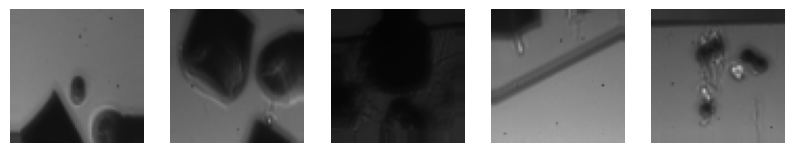

In [ ]:
import matplotlib.pyplot as plt
# Get a batch of images
images, labels = next(training_set)

# Define number of images to show
num_images = 5

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()


Based on the current page content, here are some ideas to improve the accuracy of your machine learning model:

- **Data Augmentation**: We're already using techniques like shear, zoom, and horizontal flip. Consider adding more variations such as rotation, width and height shift, and brightness change to make your model more robust to different conditions.

- **Hyperparameter Tuning**: Utilize the RandomSearch tuner to explore a wider range of hyperparameters. You can also try other optimization algorithms like Bayesian Optimization or Genetic Algorithms for potentially better results.

- **Model Architecture**: Experiment with different architectures, adding more convolutional layers, or trying pre-trained models like VGG16, ResNet, or Inception for transfer learning.

- **Regularization**: To prevent overfitting, consider using dropout layers or L1/L2 regularization in your dense layers.

Improving model accuracy is an iterative process and requires experimentation with different techniques.

In [ ]:
#Hyperparameter tuning to get best parameters
def build_model(hp):
  model = keras.Sequential()
  #Constructing a common architecture of CNN
  model.add(keras.layers.Conv2D(filters = hp.Int('conv_1_filters',min_value=16, max_value = 128, step = 16),
                                kernel_size=hp.Choice('kernel1_size',values=[3,5,7]),
                                input_shape=(64,64,3),
                                activation='relu',groups=1))
  model.add(keras.layers.MaxPool2D(pool_size = hp.Int('pool_1_size',min_value=2,max_value=8,step=1),
                                   strides=hp.Choice('strides_1',values=[1,2,3])))


  model.add(keras.layers.Conv2D(filters = hp.Int('conv_2_filters',min_value=16, max_value = 128, step = 16),
                                kernel_size=hp.Choice('kernel2_size',values=[3,5,7]),
                                activation='relu',groups=1))
  model.add(keras.layers.MaxPool2D(pool_size = hp.Int('pool_2_size',min_value=2,max_value=8,step=1),
                                   strides=hp.Choice('strides_2',values=[1,2,3])))

  model.add(keras.layers.Flatten())


  model.add(keras.layers.Dense(units=hp.Int('dense_1_layer',min_value=16,max_value=256,step=16),
                               activation='relu'))
  model.add(keras.layers.Dense(units=9,activation='sigmoid'))

  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2,1e-3])),
                                                loss='sparse_categorical_crossentropy',
                                                metrics=['accuracy'])
  return model

In [ ]:
!pip install keras-tuner
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

tunersearch = RandomSearch(build_model,objective='val_accuracy',max_consecutive_failed_trials=3,
                           max_trials=5,directory='output',project_name='Microplastic_')

tunersearch.search(training_set,
                   epochs=7,
                   validation_data=test_set)

Trial 5 Complete [00h 02m 05s]
val_accuracy: 0.6554054021835327

Best val_accuracy So Far: 0.6554054021835327
Total elapsed time: 00h 09m 43s


In [ ]:
model = tunersearch.get_best_models(num_models=1)[0]
model.summary()
# This is the model with best accuracy among the 5 trials.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 80)        6080      
                                                                 
 max_pooling2d (MaxPooling2  (None, 58, 58, 80)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        46144     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 17, 17, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 18496)             0         
                                                                 
 dense (Dense)               (None, 32)                5

In [ ]:
#Since the accuracy in the previous model is very low, differet architecture of CNN is trained
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Using vgg16 architecture

vgg = VGG16(input_shape=[224,224,3],weights = 'imagenet', include_top=False)

# Fixing vgg model layers to prevent them from losing the weights from pre-trained model
for i in vgg.layers:
  i.trainable = False
#Adding our own layers
x = GlobalAveragePooling2D()(vgg.output)
x = Dense(units = 500, activation='relu')(x)
x = Dense(units=9, activation='sigmoid')(x)
model2 = Model(inputs = vgg.input, outputs = x)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#VGG16 expects input in [224,224,3] format
training_set = train_datagen.flow_from_directory('dataset_microplastics/Train_test/train',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode='categorical')
test_set = test_datagen.flow_from_directory('dataset_microplastics/Train_test/val',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode='categorical')

model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])
model2.fit(training_set,validation_data=test_set,epochs=30)

58889256/58889256 [==============================] - 0s 0us/step
Found 571 images belonging to 9 classes.
Found 148 images belonging to 9 classes.
Epoch 1/30
18/18 [==============================] - 44s 2s/step - loss: 2.0685 - accuracy: 0.2697 - precision: 0.1658 - recall: 0.5447 - val_loss: 1.7911 - val_accuracy: 0.3514 - val_precision: 0.2304 - val_recall: 0.6959
Epoch 2/30
18/18 [==============================] - 20s 1s/step - loss: 1.7668 - accuracy: 0.3643 - precision: 0.2314 - recall: 0.6445 - val_loss: 1.6151 - val_accuracy: 0.4662 - val_precision: 0.2556 - val_recall: 0.7703
Epoch 3/30
18/18 [==============================] - 20s 1s/step - loss: 1.5874 - accuracy: 0.4343 - precision: 0.2750 - recall: 0.7285 - val_loss: 1.4314 - val_accuracy: 0.5135 - val_precision: 0.2703 - val_recall: 0.8311
Epoch 4/30
18/18 [==============================] - 20s 1s/step - loss: 1.4445 - accuracy: 0.5149 - precision: 0.2675 - recall: 0.7846 - val_loss: 1.3092 - val_accuracy: 0.5811 - val_prec

In [ ]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model2.save('final_model_microplastic.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Plotting change in loss in training

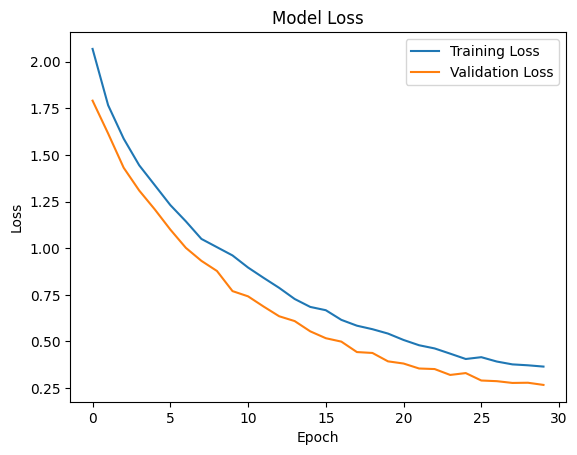

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'model2.history' contains the history callback from your training process
plt.plot(model2.history.history['loss'], label='Training Loss')
plt.plot(model2.history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


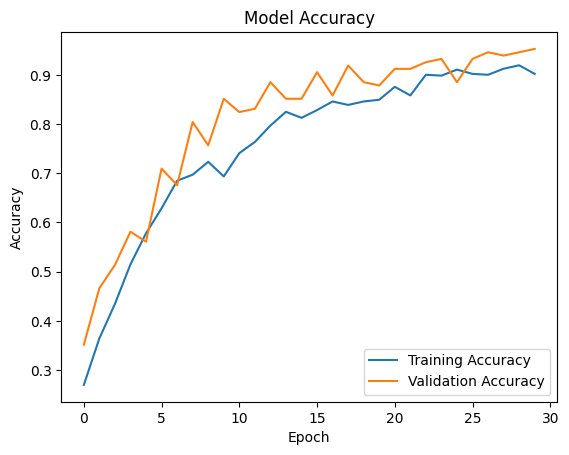

In [ ]:
# Assuming 'model2.history' contains the history callback from your training process
plt.plot(model2.history.history['accuracy'], label='Training Accuracy')
plt.plot(model2.history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.show()


In [ ]:
'''
# For testing custom image
import numpy as np
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing import image
test_image = image.load_img('path', target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model2.predict(test_image)
# decoding top 3 predictions:
print('Predicted:', decode_predictions(preds, top=3)[0])'''


"\n# For testing custom image\nimport numpy as np\nfrom keras.applications.vgg16 import decode_predictions\nfrom keras.preprocessing import image\ntest_image = image.load_img('path', target_size = (224, 224))\ntest_image = image.img_to_array(test_image)\ntest_image = np.expand_dims(test_image, axis = 0)\nresult = model2.predict(test_image)\n# decoding top 3 predictions:\nprint('Predicted:', decode_predictions(preds, top=3)[0])"

In [ ]:
import tensorflow as tf

# Create the base pre-trained model
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)

# Adding global spatial average pooling and fully-connected layers
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(9, activation='softmax')(x)

# Creating the model with the specified input and output layers
model3 = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Freeze all convolutional InceptionV3 layers for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall()])

# Train the model on the new data for a few epochs
model3.fit(training_set, validation_data=test_set, epochs=7)

# Freeze the bottom N layers and unfreeze the top layers for fine-tuning
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# Recompile the model for these changes to take effect
model3.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall()])
# Train the model on the new data for a few epochs
model3.fit(training_set, validation_data=test_set, epochs=30)


87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/7
18/18 [==============================] - 41s 1s/step - loss: 4.9860 - accuracy: 0.0000e+00 - precision_1: 0.4722 - recall_1: 0.4168 - val_loss: 0.8151 - val_accuracy: 0.0000e+00 - val_precision_1: 0.7165 - val_recall_1: 0.6149
Epoch 2/7
18/18 [==============================] - 24s 1s/step - loss: 0.6832 - accuracy: 0.0000e+00 - precision_1: 0.8544 - recall_1: 0.7706 - val_loss: 0.2870 - val_accuracy: 0.0000e+00 - val_precision_1: 0.9338 - val_recall_1: 0.8581
Epoch 3/7
18/18 [==============================] - 21s 1s/step - loss: 0.4497 - accuracy: 0.0000e+00 - precision_1: 0.8840 - recall_1: 0.8406 - val_loss: 0.2921 - val_accuracy: 0.0000e+00 - val_precision_1: 0.9375 - val_recall_1: 0.9122
Epoch 4/7
18/18 [==============================] - 20s 1s/step - loss: 0.3651 - accuracy: 0.0000e+00 - precision_1: 0.9203 - recall_1: 0.8897 - val_loss: 2.1798 - val_accuracy: 0.0000e+00 - val_precision_1: 0.4595 - val_reca

Epoch 1/30
18/18 [==============================] - 28s 1s/step - loss: 0.1894 - accuracy: 0.0016 - precision_2: 0.9518 - recall_2: 0.9335 - val_loss: 0.0697 - val_accuracy: 0.0000e+00 - val_precision_2: 0.9730 - val_recall_2: 0.9730
Epoch 2/30
18/18 [==============================] - 20s 1s/step - loss: 0.0453 - accuracy: 0.0016 - precision_2: 0.9859 - recall_2: 0.9825 - val_loss: 0.1165 - val_accuracy: 0.0023 - val_precision_2: 0.9595 - val_recall_2: 0.9595
Epoch 3/30
18/18 [==============================] - 19s 1s/step - loss: 0.0346 - accuracy: 0.0023 - precision_2: 0.9930 - recall_2: 0.9930 - val_loss: 0.0482 - val_accuracy: 7.5075e-04 - val_precision_2: 0.9864 - val_recall_2: 0.9797
Epoch 4/30
18/18 [==============================] - 20s 1s/step - loss: 0.0247 - accuracy: 0.0021 - precision_2: 0.9912 - recall_2: 0.9912 - val_loss: 0.0264 - val_accuracy: 0.0015 - val_precision_2: 0.9932 - val_recall_2: 0.9932
Epoch 5/30
18/18 [==============================] - 20s 1s/step - loss: 

In [ ]:
import tensorflow as tf  # Use TensorFlow instead of Keras for improved performance and maintainability

# Create the base pre-trained model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

# Add global spatial average pooling and fully-connected layers
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.Dense(425, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(9, activation='softmax')(x)

# Create the model with the specified input and output layers
model5 = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Freeze all convolutional InceptionV3 layers for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall()])

# Train the model on the new data for a few epochs
model5.fit(training_set, validation_data=test_set, epochs=30)


Epoch 1/30
18/18 [==============================] - 27s 1s/step - loss: 2.6536 - accuracy: 0.0000e+00 - precision_10: 0.2308 - recall_10: 0.0736 - val_loss: 2.0885 - val_accuracy: 0.0000e+00 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 2/30
18/18 [==============================] - 22s 1s/step - loss: 2.2521 - accuracy: 0.0000e+00 - precision_10: 0.2456 - recall_10: 0.0245 - val_loss: 2.0877 - val_accuracy: 0.0000e+00 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 3/30
18/18 [==============================] - 21s 1s/step - loss: 2.1685 - accuracy: 0.0000e+00 - precision_10: 0.2353 - recall_10: 0.0070 - val_loss: 2.0675 - val_accuracy: 0.0000e+00 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 4/30
18/18 [==============================] - 22s 1s/step - loss: 2.1323 - accuracy: 0.0000e+00 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - val_loss: 2.0607 - val_accuracy: 0.0000e+00 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0

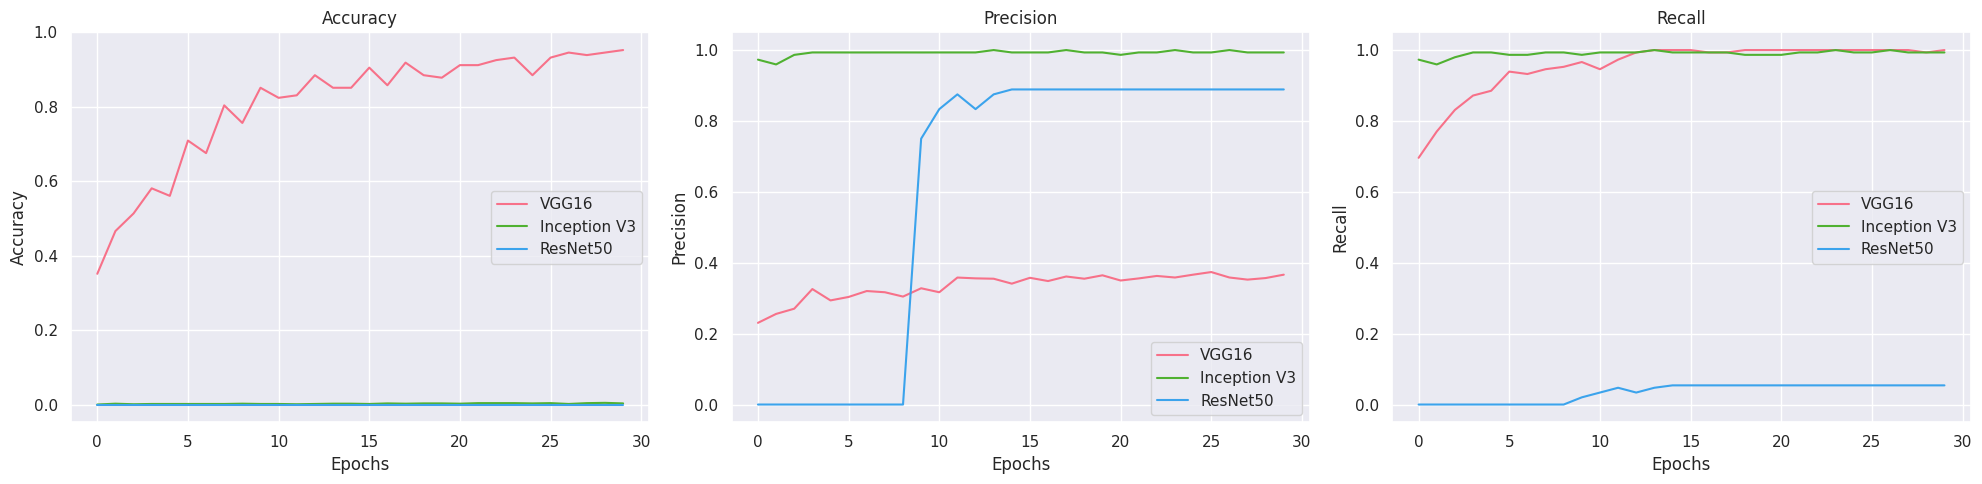

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set_theme()

# Set a custom color palette
colors = sns.color_palette("husl", 3)

# Set figure size
plt.figure(figsize=(20, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 3, 1)
sns.lineplot(model2.history.history['val_accuracy'], label='VGG16', color=colors[0])
sns.lineplot(model3.history.history['val_accuracy'], label='Inception V3', color=colors[1])
sns.lineplot(model5.history.history['val_accuracy'], label='ResNet50', color=colors[2])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Precision
plt.subplot(1, 3, 2)
sns.lineplot(model2.history.history['val_precision'], label='VGG16', color=colors[0])
sns.lineplot(model3.history.history['val_precision_2'], label='Inception V3', color=colors[1])
sns.lineplot(model5.history.history['val_precision_10'], label='ResNet50', color=colors[2])
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Plot Recall
plt.subplot(1, 3, 3)
sns.lineplot(model2.history.history['val_recall'], label='VGG16', color=colors[0])
sns.lineplot(model3.history.history['val_recall_2'], label='Inception V3', color=colors[1])
sns.lineplot(model5.history.history['val_recall_10'], label='ResNet50', color=colors[2])
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
#Since the accuracy in the previous model is very low, differet architecture of CNN is trained
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Using vgg16 architecture

vgg = VGG16(input_shape=[224,224,3],weights = 'imagenet', include_top=False)

# Fixing vgg model layers to prevent them from losing the weights from pre-trained model

#Adding our own layers
x = GlobalAveragePooling2D()(vgg.output)
x = Dense(units = 500, activation='relu')(x)
x = Dense(units=9, activation='sigmoid')(x)
model4 = Model(inputs = vgg.input, outputs = x)
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#VGG16 expects input in [224,224,3] format
training_set = train_datagen.flow_from_directory('dataset_microplastics/Train_test/train',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode='categorical')
test_set = test_datagen.flow_from_directory('dataset_microplastics/Train_test/val',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode='categorical')
for i in vgg.layers:
  i.trainable = False
model4.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])
model4.fit(training_set,validation_data=test_set,epochs=7)

for layer in model4.layers[:22]:
    layer.trainable = False
for layer in model4.layers[22:]:
    layer.trainable = True

# Recompile the model for these changes to take effect
model4.compile(optimizer='adam',
              loss='categorical_crossentropy', metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall()])
# Train the model on the new data for a few epochs
model4.fit(training_set, validation_data=test_set, epochs=30)


Found 571 images belonging to 9 classes.
Found 148 images belonging to 9 classes.
Epoch 1/7
18/18 [==============================] - 23s 1s/step - loss: 2.0256 - accuracy: 0.2662 - precision_8: 0.1574 - recall_8: 0.7373 - val_loss: 1.8373 - val_accuracy: 0.2635 - val_precision_8: 0.1725 - val_recall_8: 0.8311
Epoch 2/7
18/18 [==============================] - 19s 1s/step - loss: 1.7602 - accuracy: 0.3573 - precision_8: 0.1829 - recall_8: 0.8354 - val_loss: 1.6212 - val_accuracy: 0.3649 - val_precision_8: 0.2159 - val_recall_8: 0.8784
Epoch 3/7
18/18 [==============================] - 20s 1s/step - loss: 1.5852 - accuracy: 0.4378 - precision_8: 0.2182 - recall_8: 0.8862 - val_loss: 1.4188 - val_accuracy: 0.5473 - val_precision_8: 0.2268 - val_recall_8: 0.8919
Epoch 4/7
18/18 [==============================] - 24s 1s/step - loss: 1.4215 - accuracy: 0.5499 - precision_8: 0.2308 - recall_8: 0.9002 - val_loss: 1.2963 - val_accuracy: 0.5811 - val_precision_8: 0.2623 - val_recall_8: 0.9392
Ep

KeyboardInterrupt: 